In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading the data into dataframe
df = pd.read_csv('Twitter_Data.csv')

In [3]:
# Dropping missing values
df = df.dropna()

In [4]:
# Displaying data information and checking for missing values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162969 non-null  object 
 1   category    162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB
None


In [5]:
print(df.isnull().sum())

clean_text    0
category      0
dtype: int64


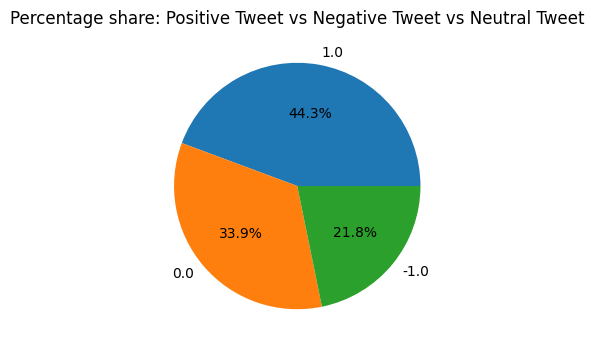

In [6]:
# Visualizing category distribution
plt.figure(figsize=[4, 4])
plt.pie(df['category'].value_counts(), labels=df['category'].value_counts().index, autopct='%1.1f%%')
plt.title('Percentage share: Positive Tweet vs Negative Tweet vs Neutral Tweet')
plt.show()

In [7]:
# Downloading stopwords
nltk.download('stopwords', quiet=True)

True

In [8]:
# Text preprocessing function
pattern = re.compile('[^a-zA-Z]')
english_stopwords = stopwords.words('english')
port_stemmer = PorterStemmer()

In [9]:
def preprocessed_text(text):
    text = re.sub(pattern, ' ', text)
    text = text.lower()
    text = text.split()
    text = [port_stemmer.stem(word) for word in text if word not in english_stopwords]
    return ' '.join(text)

In [10]:
# Applying the function
df['stemmed_content'] = df['clean_text'].apply(preprocessed_text)

In [11]:
# Visualizing word clouds
def plot_word_clouds(df, category, title_before, title_after):
    raw_text = " ".join([sentence for sentence in df[category]['clean_text']])
    processed_text = " ".join([sentence for sentence in df[category]['stemmed_content']])
    wordcloud_raw = WordCloud(width=800, height=400, max_font_size=110).generate(raw_text)
    wordcloud_processed = WordCloud(width=800, height=400, max_font_size=110).generate(processed_text)
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].imshow(wordcloud_raw, interpolation='bilinear')
    axes[0].set_title(title_before, fontsize=20)
    axes[0].axis('off')
    
    axes[1].imshow(wordcloud_processed, interpolation='bilinear')
    axes[1].set_title(title_after, fontsize=20)
    axes[1].axis('off')
    plt.show()

In [12]:
categories = {
    "all": df,
    "positive": df[df["category"]==1],
    "negative": df[df["category"]==-1],
    "neutral": df[df["category"]==0]
}


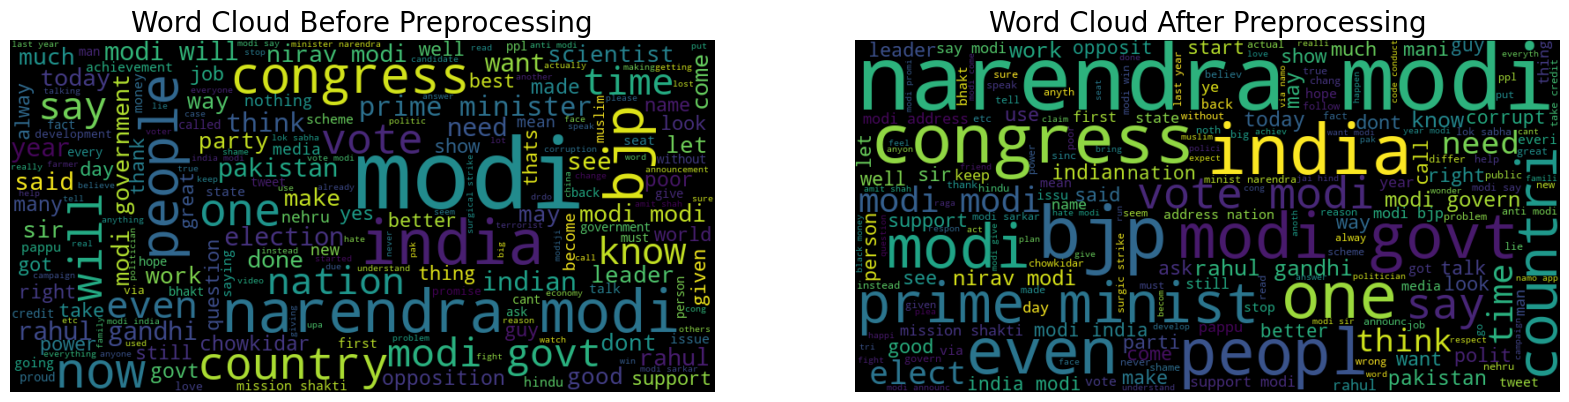

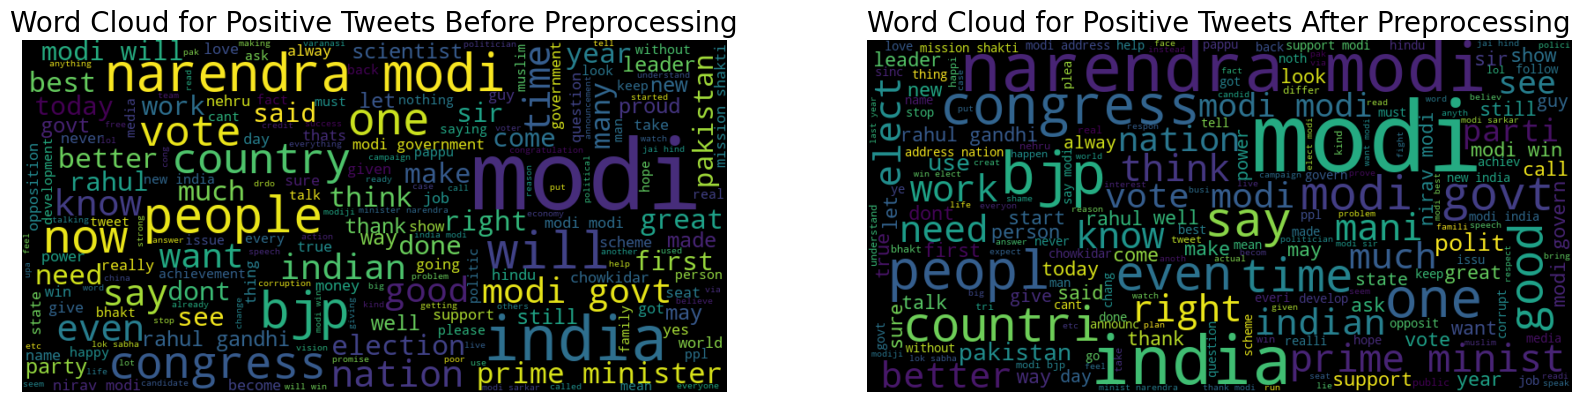

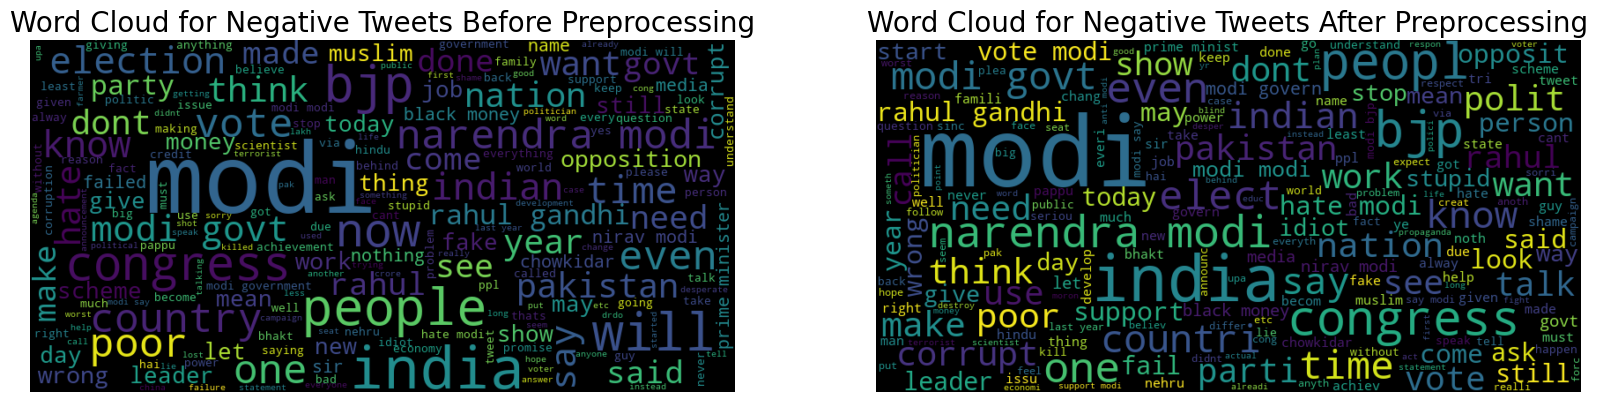

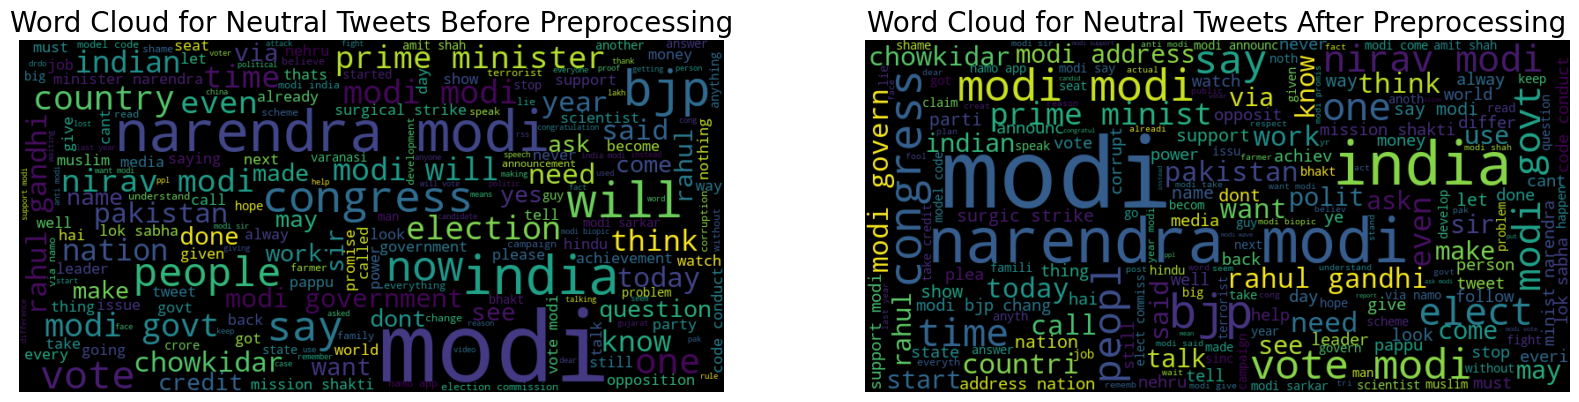

In [13]:
plot_word_clouds(categories["all"], slice(None), 'Word Cloud Before Preprocessing', 'Word Cloud After Preprocessing')
plot_word_clouds(categories["positive"], slice(None), 'Word Cloud for Positive Tweets Before Preprocessing', 'Word Cloud for Positive Tweets After Preprocessing')
plot_word_clouds(categories["negative"], slice(None), 'Word Cloud for Negative Tweets Before Preprocessing', 'Word Cloud for Negative Tweets After Preprocessing')
plot_word_clouds(categories["neutral"], slice(None), 'Word Cloud for Neutral Tweets Before Preprocessing', 'Word Cloud for Neutral Tweets After Preprocessing')

In [14]:
# Preparing data for training and testing
X = df['stemmed_content']
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

In [15]:
# Vectorizing text data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [16]:
# Logistic Regression model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)
y_pred = lr.predict(X_test_tfidf)

In [17]:
# Displaying results
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.84
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.82      0.71      0.76      7102
         0.0       0.82      0.91      0.86     11042
         1.0       0.88      0.86      0.87     14450

    accuracy                           0.84     32594
   macro avg       0.84      0.83      0.83     32594
weighted avg       0.84      0.84      0.84     32594



In [18]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[ 5040   936  1126]
 [  339 10058   645]
 [  752  1284 12414]]


In [19]:
# Save the model
import pickle
filename = 'tweet_lr_model.pkl'
pickle.dump(lr, open(filename, 'wb'))

In [20]:
# Additional preprocessing function for new tweets
def preprocess_tweet(tweet):
    tweet = str(tweet)
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'#\w+', '', tweet)
    tweet = re.sub(r'\d+', '', tweet)
    tweet = re.sub(r'\W+', ' ', tweet)
    return tweet.strip()

In [21]:
# Analyzing new tweet sentiment
def analyze_tweet_sentiment(tweet, model, vectorizer):
    tweet_vectorized = vectorizer.transform([tweet])
    sentiment = model.predict(tweet_vectorized)[0]
    if sentiment == 1:
        return "The sentiment for the previous tweet is positive."
    elif sentiment == 0:
        return "The sentiment for the previous tweet is neutral."
    else:
        return "The sentiment for the previous tweet is negative."

In [24]:
new_tweet = input("Enter a tweet: ")
preprocessed_tweet = preprocess_tweet(new_tweet)
print("")
print(analyze_tweet_sentiment(preprocessed_tweet, lr, vectorizer))

Enter a tweet:  modi is not better person



The sentiment for the previous tweet is positive.
